<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/hypotension_mbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypotension prediction using mean blood pressure values

In this sample code, we will try to build a machine learning based model for predicting hypotension (MBP < 65mmHg for more than 1 minute) from the mean blood pressure (MBP) value read from the patient monitor (GE Solar 8000M) on VitalDB dataset.

## Required libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

!pip install vitaldb
import vitaldb

     |████████████████████████████████| 50 kB 2.7 MB/s 
     |████████████████████████████████| 140 kB 21.5 MB/s 
     |████████████████████████████████| 1.1 MB 54.0 MB/s 
     |████████████████████████████████| 104 kB 59.1 MB/s 
     |████████████████████████████████| 8.6 MB 42.8 MB/s 
     |████████████████████████████████| 94 kB 1.6 MB/s 
     |████████████████████████████████| 271 kB 60.1 MB/s 
     |████████████████████████████████| 144 kB 50.6 MB/s 
     |████████████████████████████████| 127 kB 55.8 MB/s 
  Created wheel for aiobotocore: filename=aiobotocore-2.3.2-py3-none-any.whl size=111119 sha256=26795d9d7cd96a440a08f9fa8d7cc9c3511c709dfe297bd69859b2504604455b
  Stored in directory: /root/.cache/pip/wheels/fb/48/61/f6b53f097fd8c9c14427058ee2c849ce3471ec1d7fa6039457
Successfully built aiobotocore
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency 

## Case Selection

In [ ]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

# inclusion & exclusion criteria
caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) & \
    set(df_cases[df_cases['age'] > 18]['caseid']) & \
    set(df_cases[df_cases['caseend'] > 3600]['caseid']) & \
    set(df_cases[~df_cases['opname'].str.contains("transplant")]['caseid'])
)
print('Total {} cases found'.format(len(caseids)))
np.random.shuffle(caseids)  # shuffle caseids

Total 3420 cases found


## Preprocessing

In this section, we will read the MBP data while iterating caseids. Only MAX_CASES (=100) cases will be used for to save time.

The MBP data of each case will be read by passing the caseid into the vitaldb python library. Then, the pairs of x (input) and y (label) for training and validation of the model will be extracted.

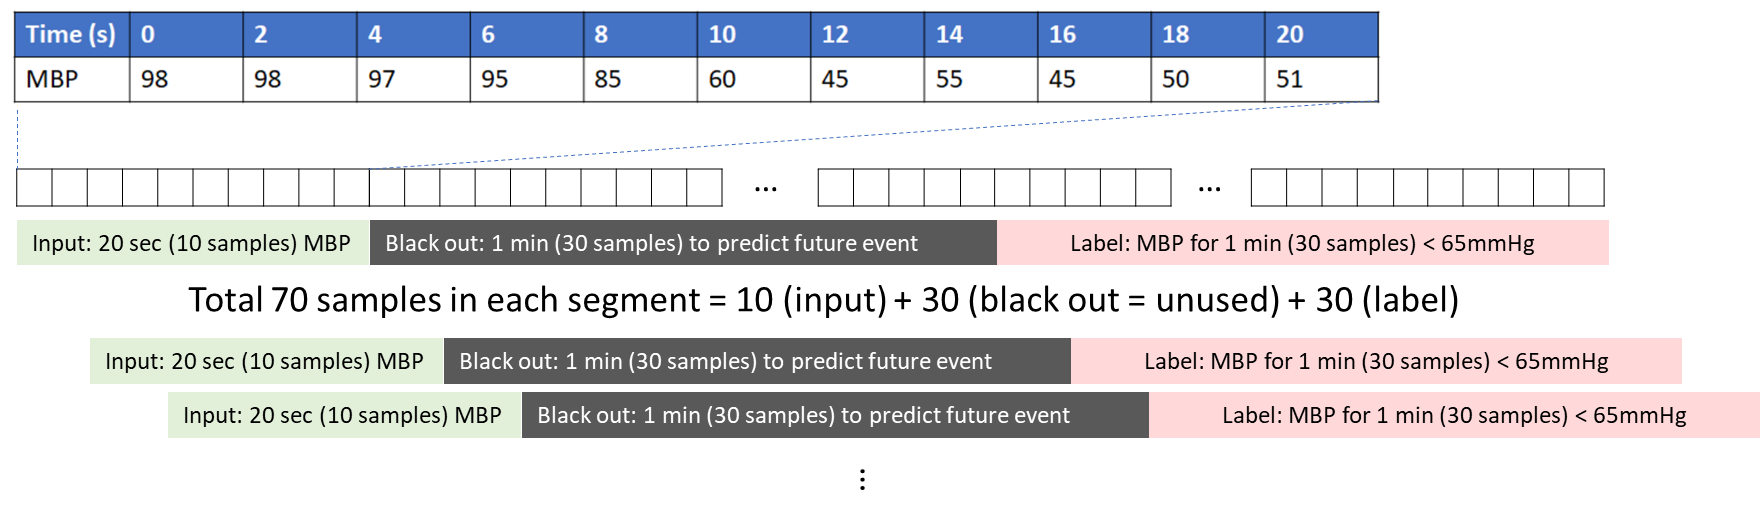

In [ ]:
MINUTES_AHEAD = 1  # Predict hypotension 1 minutes ahead
LSTM_NODES = 16  # Number of cells in LSTM
BATCH_SIZE = 256  # Batch size for learning
MAX_CASES = 100  # Maximum number of cases for this example

# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the mean blood pressure with 2 min interval
    mbps = vitaldb.load_case(caseid, ['Solar8000/ART_MBP'], 2).flatten()

    # samples before arterial catheter inserted
    mbps[mbps < 40] = np.nan

    # removing the nan values at the beginning and the ending
    case_valid_mask = ~np.isnan(mbps)
    mbps = mbps[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]

    case_sample = 0
    case_event = 0
    for i in range(0, len(mbps) - (10 + MINUTES_AHEAD * 30 + 30)):
        segx = mbps[i:i + 10]
        segy = mbps[i + 10 + MINUTES_AHEAD * 30:i + 10 + MINUTES_AHEAD * 30 + 30]

        # check the validity of this segment
        valid = True
        if np.isnan(segx).mean() > 0.1:
            valid = False
        if np.isnan(segy).mean() > 0.1:
            valid = False
        elif (segx > 150).any():
            valid = False
        elif (segy > 150).any():
            valid = False
        elif (np.abs(np.diff(segx)) > 50).any():  # abrupt change -> noise
            valid = False
        elif (np.abs(np.diff(segy)) > 50).any():  # abrupt change -> noise
            valid = False

        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)
        
        if valid:
            case_sample += 1
            if evt:
                case_event += 1

    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('no samples')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

x = x[...,None]  # add 3rd axis for input of LSTM

print(x.shape)
print(y.shape)

loading 3345...8303 samples 642 (7.7 %) events
loading 4727...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: All-NaN slice encountered


2055 samples 0 (0.0 %) events
loading 4976...7381 samples 937 (12.7 %) events
loading 1436...6913 samples 0 (0.0 %) events
loading 1812...5804 samples 783 (13.5 %) events
loading 5765...2812 samples 118 (4.2 %) events
loading 1143...2859 samples 81 (2.8 %) events
loading 4805...6996 samples 625 (8.9 %) events
loading 2655...3199 samples 146 (4.6 %) events
loading 5583...3901 samples 108 (2.8 %) events
loading 5887...4387 samples 7 (0.2 %) events
loading 1605...9701 samples 0 (0.0 %) events
loading 1094...13444 samples 142 (1.1 %) events
loading 2304...9246 samples 1541 (16.7 %) events
loading 6242...5983 samples 0 (0.0 %) events
loading 4483...5887 samples 0 (0.0 %) events
loading 4341...13302 samples 340 (2.6 %) events
loading 2333...4892 samples 0 (0.0 %) events
loading 4703...1179 samples 374 (31.7 %) events
loading 5822...3423 samples 0 (0.0 %) events
loading 2815...5582 samples 50 (0.9 %) events
loading 3935...3781 samples 26 (0.7 %) events
loading 879...2729 samples 156 (5.7 %) e

## Splitting samples into training and testing dataset


In [ ]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# train set과 test set 으로 나눔
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

# invalid samples in test dataset is also needed for plotting
test_x = x[test_mask]
test_y = y[test_mask]
test_c = c[test_mask]

# only valid samples are required for the training dataset
train_x_valid = x[train_mask & valid_mask]
train_y_valid = y[train_mask & valid_mask]
test_x_valid = x[test_mask & valid_mask]
test_y_valid = y[test_mask & valid_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'100cases 1ahead batchsize=256 total 617380, train 447687 (25499 events 5.7%), test 124993 (3095 events 2.5%)'

## Model building and training

In [ ]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
1568/1574 [============================>.] - ETA: 0s - loss: 0.2536 - accuracy: 0.9362 - auc: 0.9605
Epoch 1: val_loss improved from inf to 0.20542, saving model to output/weights.hdf5
1574/1574 [==============================] - 18s 7ms/step - loss: 0.2536 - accuracy: 0.9362 - auc: 0.9605 - val_loss: 0.2054 - val_accuracy: 0.9276 - val_auc: 0.9815
Epoch 2/100
1569/1574 [============================>.] - ETA: 0s - loss: 0.2030 - accuracy: 0.9503 - auc: 0.9700
Epoch 2: val_loss improved from 0.20542 to 0.12431, saving model to output/weights.hdf5
1574/1574 [==============================] - 9s 6ms/step - loss: 0.2030 - accuracy: 0.9503 - auc: 0.9699 - val_loss: 0.1243 - val_accuracy: 0.9492 - val_auc: 0.9814
Epoch 3/100
1565/1574 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9499 - auc: 0.9698
Epoch 3: val_loss did not improve from 0.12431
1574/1574 [==============================] - 9s 6ms/step - loss: 0.2028 - accuracy: 0.9499 - auc: 0.9698 - val_

2125

## Evaluation of the model performance

In [ ]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# rename final output folder
odir = testname + ' ' + testres
os.rename(tempdir, odir)

# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(odir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(odir))
plt.close()

auroc=0.978, auprc=0.534 acc=0.977, F1=0.536, PPV=54.0, NPV=98.8, TN=120498, fp=1400, fn=1450, TP=1645


## Plotting each case in the test dataset

5617	0.02598893419520872	


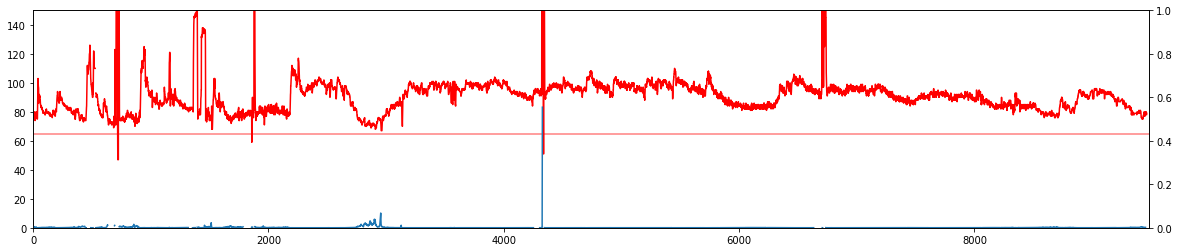

5694	0.12253145092108826	


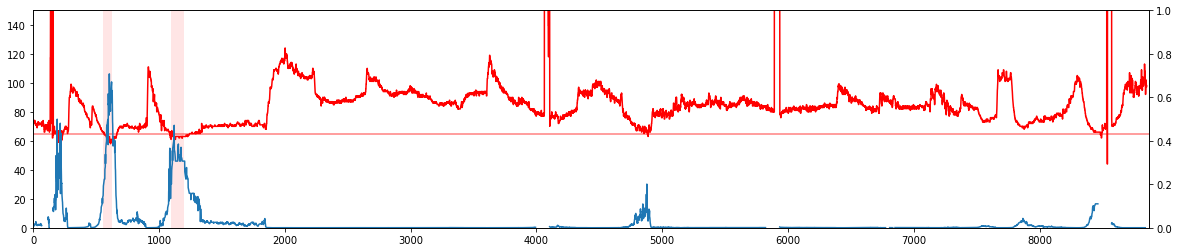

5733	0.04173330275307145	


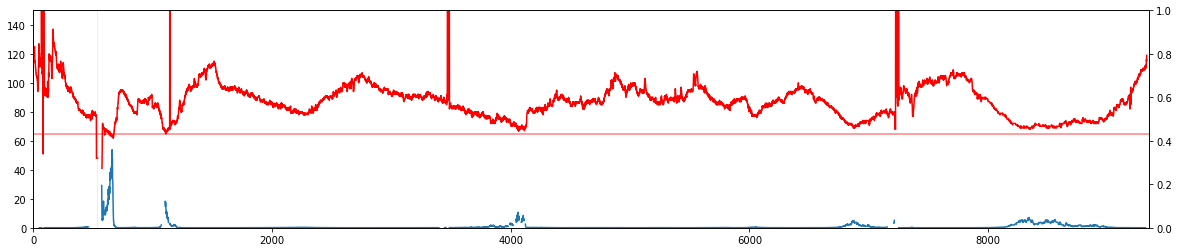

5765	0.17677777003800688	


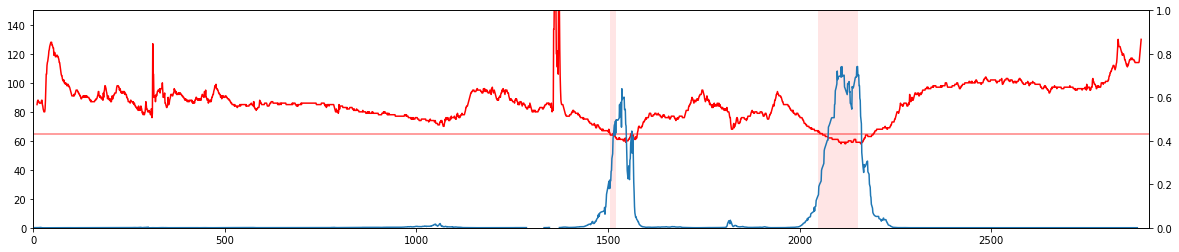

5793	0.01329281442400876	


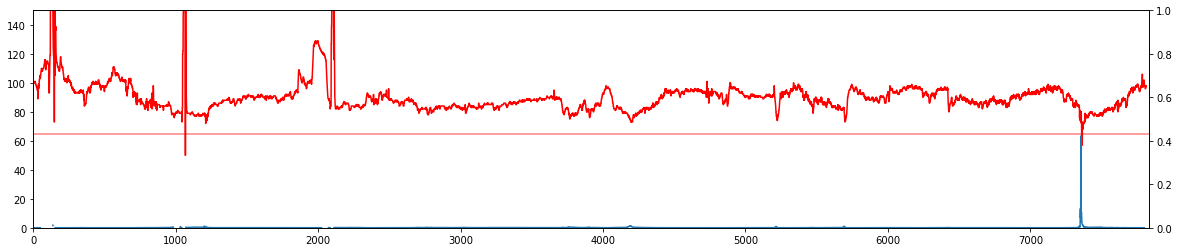

5814	0.14659055676150776	


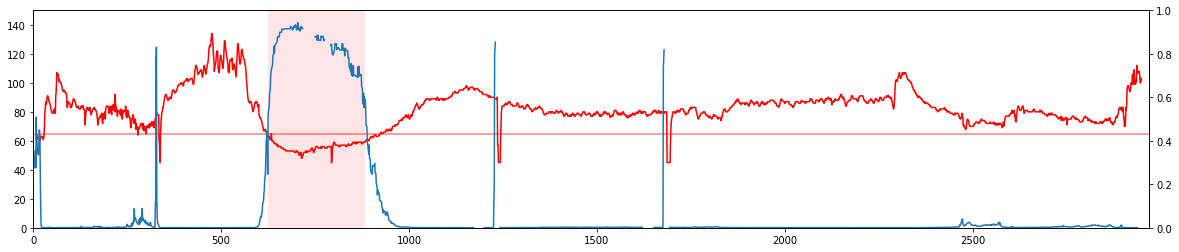

5822	0.035406413059309465	


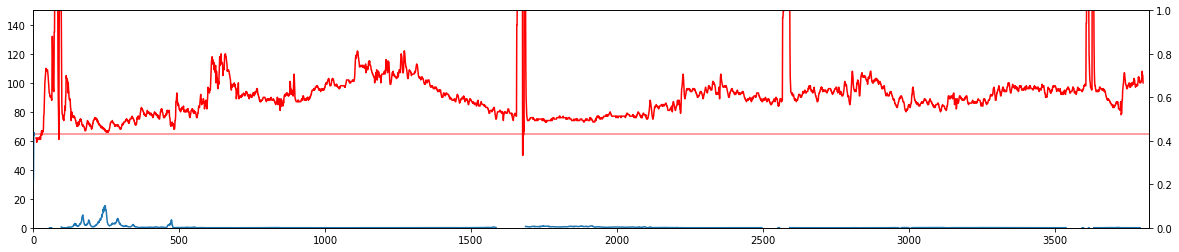

5887	0.07725447598393989	


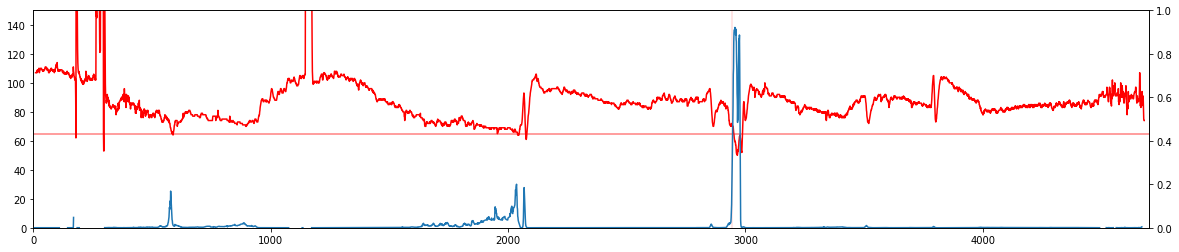

5982	0.47028758277662175	


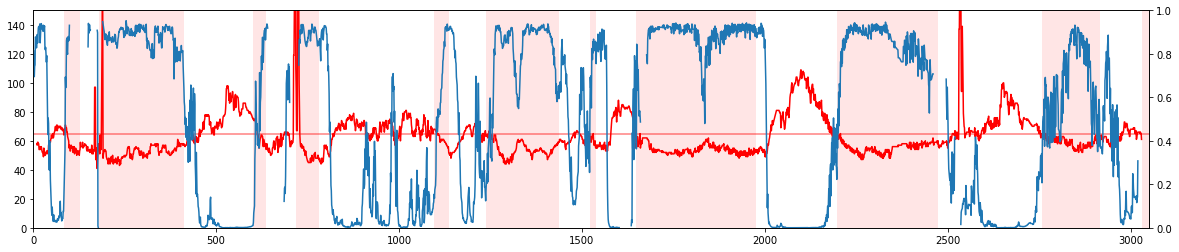

6020	0.07097902551932185	


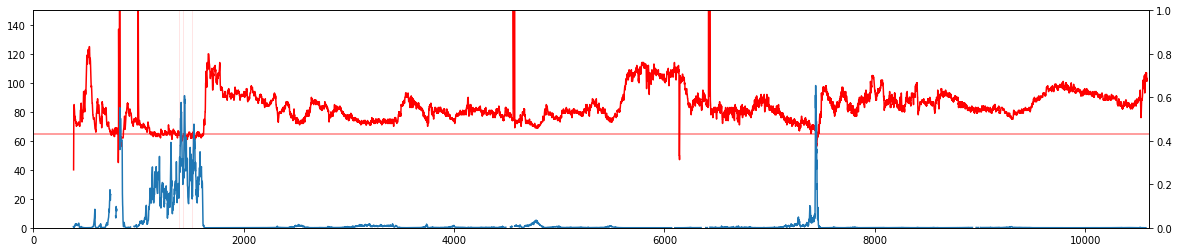

6039	0.17397850475505883	


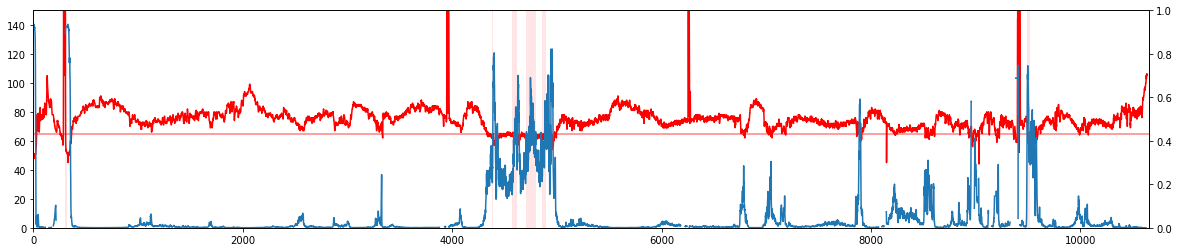

6057	0.0007973755664487306	


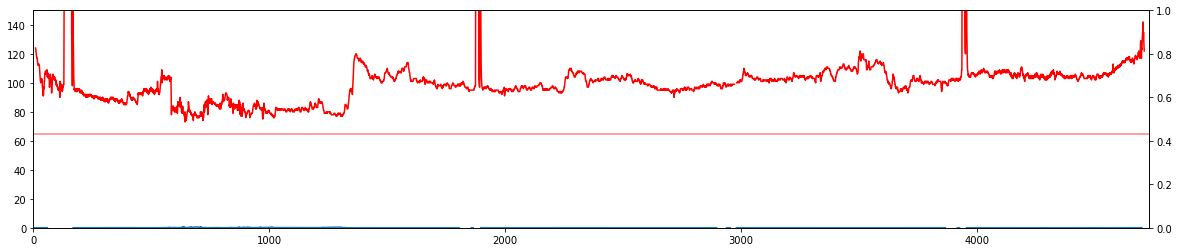

6176	0.052457635204654254	


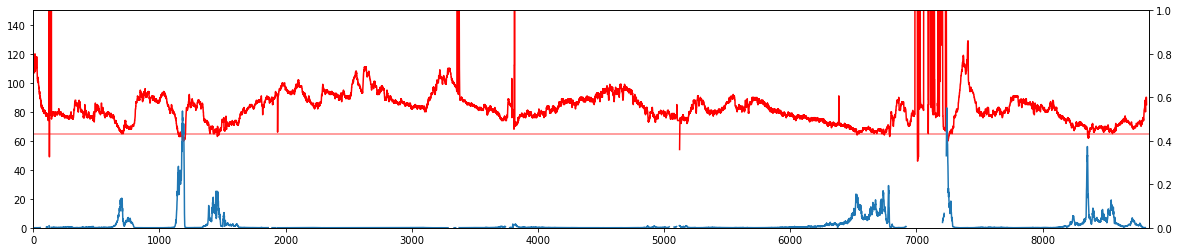

6185	0.009309093206215351	


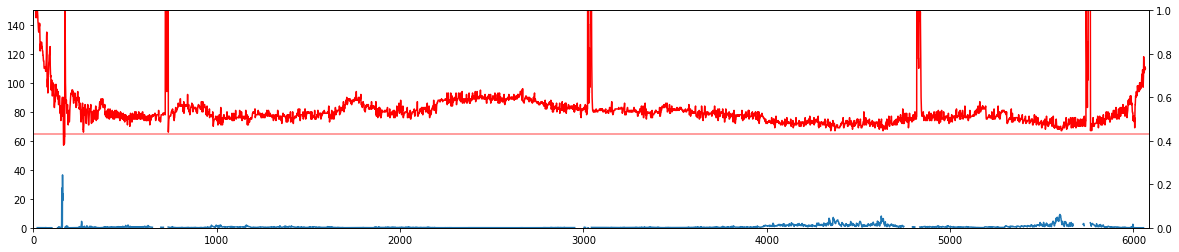

6242	0.03099091518886649	


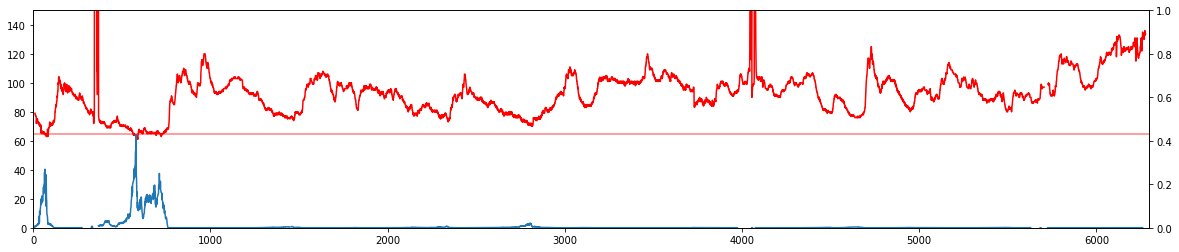

6270	0.10661450771878234	


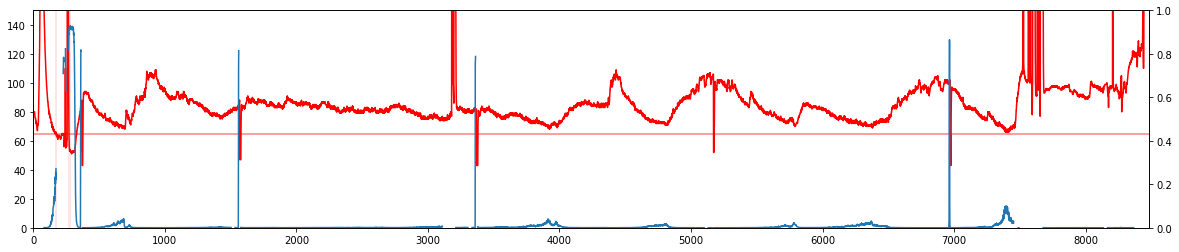

6283	0.17013152660986275	


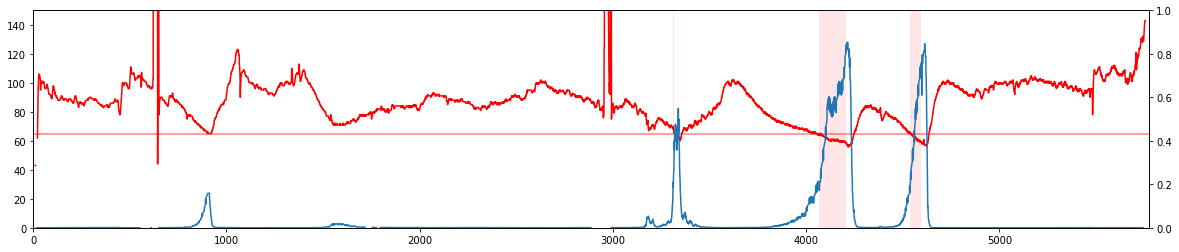

6293	0.24842123632158783	


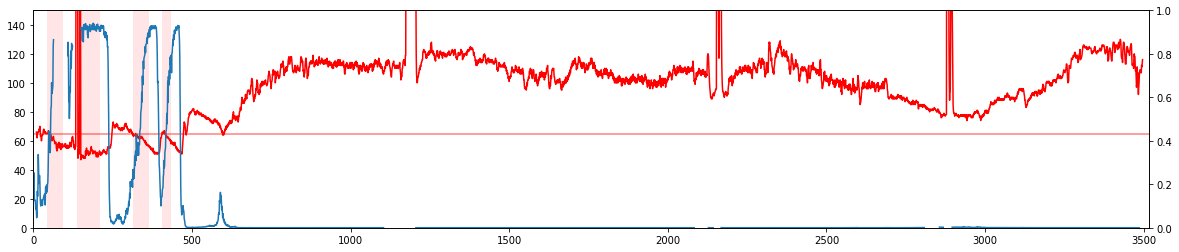

6375	0.2905188294773926	


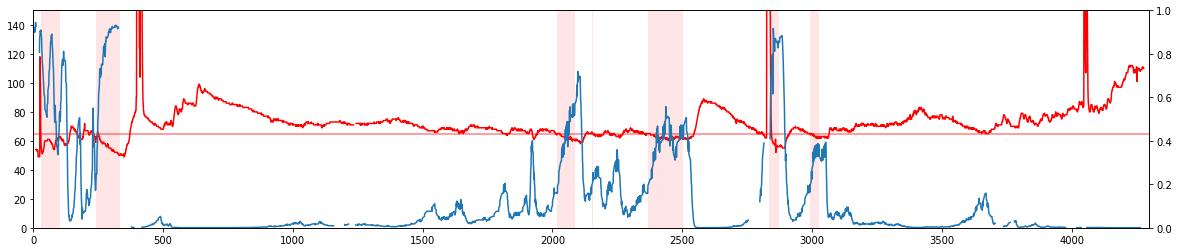

6378	0.11769252673782488	


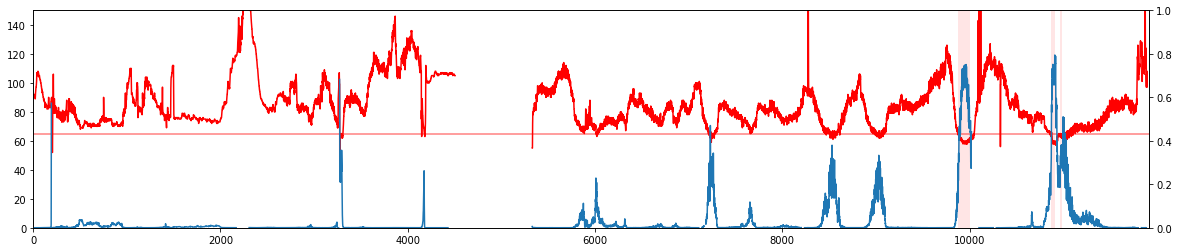

In [ ]:
for caseid in caseids_test:
    case_mask = (c == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = x[case_mask]
    case_y = y[case_mask]
    case_valid_mask = valid_mask[case_mask]
    
    # calculate error for this case
    case_predy = model.predict(case_x).flatten()
    case_rmse = np.nanmean((case_y - case_predy) ** 2) ** 0.5
    print('{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, case_x[:,-1], color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples
    case_predy[~case_valid_mask] = np.nan
    ax2.plot(t, case_predy)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()